In [1]:
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import os
path = r"c:\Users\user\Desktop\TIPA\코드-20220207T014959Z-001\코드\simple_images\bar_chart"
file_list = os.listdir(path)
file_list

['bar chart_1.png',
 'bar chart_10.png',
 'bar chart_100.png',
 'bar chart_1000.png',
 'bar chart_1001.png',
 'bar chart_1002.png',
 'bar chart_1003.png',
 'bar chart_1004.png',
 'bar chart_1005.png',
 'bar chart_1006.png',
 'bar chart_1007.png',
 'bar chart_1008.png',
 'bar chart_1009.png',
 'bar chart_101.jpeg',
 'bar chart_1010.png',
 'bar chart_1011.jpeg',
 'bar chart_1012.png',
 'bar chart_1013.png',
 'bar chart_1014.png',
 'bar chart_1015.jpeg',
 'bar chart_1016.png',
 'bar chart_1017.png',
 'bar chart_1018.png',
 'bar chart_1019.jpeg',
 'bar chart_102.png',
 'bar chart_1020.png',
 'bar chart_1021.png',
 'bar chart_1022.png',
 'bar chart_1023.png',
 'bar chart_1024.png',
 'bar chart_1025.png',
 'bar chart_1026.png',
 'bar chart_1027.png',
 'bar chart_1028.png',
 'bar chart_1029.png',
 'bar chart_103.png',
 'bar chart_1030.png',
 'bar chart_1031.png',
 'bar chart_1032.jpeg',
 'bar chart_1033.png',
 'bar chart_1034.png',
 'bar chart_1035.png',
 'bar chart_1036.png',
 'bar chart_103

In [5]:
f = open("BarGraph.csv", "w")

for i in range(len(file_list)):
    f.write(file_list[i] + ',' + 'BarGraph' + '\n')
f.close()


In [4]:
column_name = ['chart', 'type']
dataframe = pd.read_csv(r'C:\Users\user\Desktop\TIPA\코드-20220207T014959Z-001\코드\data\all_data.csv')

data = dataframe.values.tolist()

new_dataframe = pd.DataFrame(data, columns=column_name)

In [6]:
traindf = new_dataframe
traindf['code'] = traindf['type'].astype('category').cat.codes
traindf.head(5000)

,chart,type,code
0,bar chart_10.png,BarChart,0
1,bar chart_100.png,BarChart,0
2,bar chart_1000.png,BarChart,0
3,bar chart_1001.png,BarChart,0
4,bar chart_1002.png,BarChart,0
...,...,...,...
4995,bar graph_2796.png,BarGraph,1
4996,bar graph_2797.jpeg,BarGraph,1
4997,bar graph_2798.jpeg,BarGraph,1
4998,bar graph_2799.png,BarGraph,1


In [7]:
def createModel():
    vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

    for layer in vgg_model.layers[:-5]:
        layer.trainable=False
        
    input = Input(shape=(224, 224, 3), name = 'image_input')
    output_vgg19_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg19_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(13, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

In [8]:
def printHistory(history, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle("VGG-19", fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [9]:
def trainModelDF(images, epochs, cross_validation_folds):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1)

    datagen_valid = ImageDataGenerator(rescale=1./255)
            
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.code
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")

        model = createModel()
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory=r"C:\Users\user\Desktop\TIPA\코드-20220207T014959Z-001\코드\simple_images\all_images",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));

        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory=r"C:\Users\user\Desktop\TIPA\코드-20220207T014959Z-001\코드\simple_images\all_images",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)
                
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

In [10]:
trainModelDF(
    traindf,
    cross_validation_folds = 5,
    epochs = 10
)

Train Model
Cross validation
Iteration =  1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)    

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 939 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  warnings.warn(


Found 23766 validated image filenames belonging to 10 classes.


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 240 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 5937 validated image filenames belonging to 10 classes.
Epoch 1/10


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[32,13] labels_size=[32,10]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at \Temp/ipykernel_25344/4147129150.py:56) ]] [Op:__inference_train_function_2860]

Function call stack:
train_function


In [2]:
def trainFinalModel(images, epochs):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1)
    
    print("======================================")    
    model = createModel()
    print("======================================")
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                  directory=r"c:\Users\user\Desktop\TIPA\코드-20220207T014959Z-001\코드\simple_images\bar_chart",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));
        
    STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
    
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit_generator(generator = train_generator,\
                        steps_per_epoch = STEP_SIZE_TRAIN, \
                        epochs = epochs, \
                        verbose = 1)

In [3]:
trainFinalModel(
    traindf,
    epochs = 30
)

NameError: name 'traindf' is not defined

In [1]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [ ]:
testdf = pd.read_csv('test.csv')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = "./../DataMining/AllData/filtered/images/",
    x_col = "chart",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224, 224))

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

In [ ]:
predicted_class_indices = np.argmax(pred, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("predictions.csv", index = False)

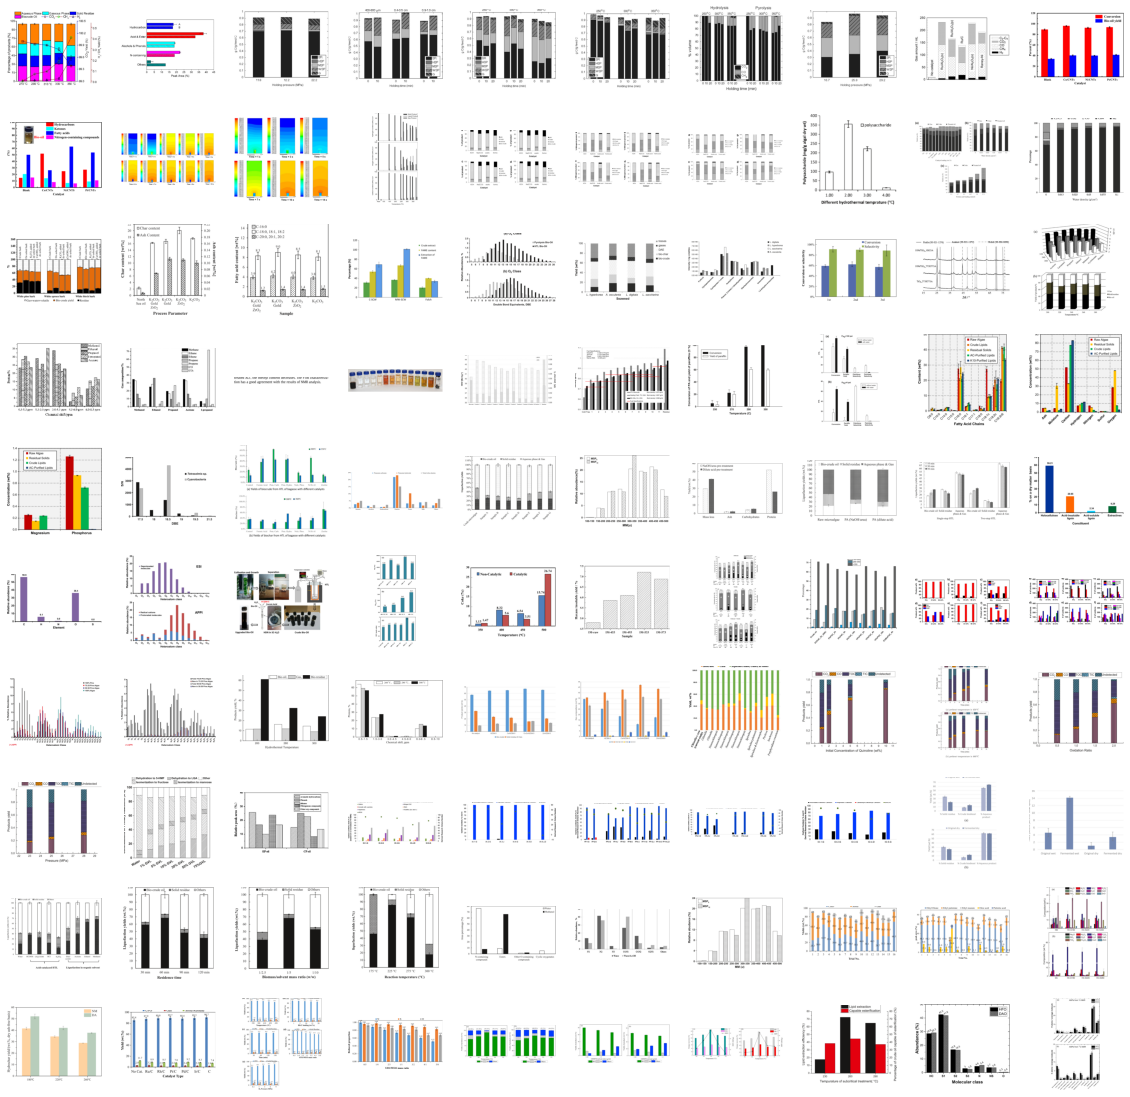

In [7]:
barplots = results.loc[results['type'] == 'BarGraph']

f, ax = plt.subplots(10, 10, figsize = (20, 20))

for index in range(100):
    ax[index // 10, index % 10].imshow(mpimg.imread("./../../DataMining/AllData/filtered/images/" + barplots.iloc[index]['chart']))
    ax[index // 10, index % 10].axis('off')
    ax[index // 10, index % 10].set_aspect('equal')
    
plt.show()